In [8]:
# 그림을 저장할 위치
import os
PROJECT_ROOT_DIR = "./fdr_output"
CHAPTER_ID = "stock_check"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
SAMPLES_PATH = os.path.join(PROJECT_ROOT_DIR, "samples", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(SAMPLES_PATH, exist_ok=True)

#파일 경로 생성함수
def mkfile(file): 
    file = os.path.join(SAMPLES_PATH,f'{file}.xlsx')
    return file

sample_o = os.path.join(SAMPLES_PATH,'sample.xlsx')
test = os.path.join(SAMPLES_PATH,'test.xlsx')
sample_modi = os.path.join(SAMPLES_PATH,'sample_modi.xlsx')
sample_modi1 = os.path.join(SAMPLES_PATH,'sample_modi1.xlsx')

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 결측치제거 및 scaling
def scale(df):
    from sklearn.preprocessing import MinMaxScaler
    import pandas as pd
    df = df.fillna(method='pad').dropna(axis=0)
    scaler = MinMaxScaler()
    scaler.fit(df)
    output = scaler.transform(df)
    output = pd.DataFrame(output, columns=df.columns, index=df.index.values)
    return output
    
# 시각화
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

mpl.rcParams['axes.unicode_minus'] = False
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (12,6)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["axes.formatter.limits"] = -10000, 10000
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### 선행지수

[선행지표 확인](https://nbviewer.jupyter.org/github/FinanceData/FinanceDataReader/blob/master/tutorial/FinanceDataReader%20Tutorial%20-%20FRED%20%EA%B2%BD%EA%B8%B0%20%EC%84%A0%ED%96%89%20%EC%A7%80%ED%91%9C.ipynb)
+ 주간 실업수당 청구 건수 (ICSA)
+ 소비자심리지수 (UMCSENT)
+ 주택 판매 지수 (HSN1F)
+ 실업률 (UNRATE)
+ M2 통화량(M2)
+ 하이일드 채권 스프레드 (BAMLH0A0HYM2)

In [10]:
import FinanceDataReader as fdr
df = fdr.DataReader(['NASDAQCOM', 'ICSA', 'UMCSENT','HSN1F','UNRATE','M2','BAMLH0A0HYM2'],'2019', data_source='fred')
col = ['나스닥','실업수당건수','소비자심리지수','주택판매지수','실업률','M2','H채권스프레드']
df = scale(df)
df.columns = col
df.corr()

,나스닥,실업수당건수,소비자심리지수,주택판매지수,실업률,M2,H채권스프레드
나스닥,1.000000,0.001474,-0.633868,0.806852,0.393213,0.905165,0.078680
실업수당건수,0.001474,1.000000,-0.623550,-0.042900,0.733763,0.382488,0.819737
소비자심리지수,-0.633868,-0.623550,1.000000,-0.528375,-0.878027,-0.866214,-0.618552
주택판매지수,0.806852,-0.042900,-0.528375,1.000000,0.287625,0.760606,-0.084077
실업률,0.393213,0.733763,-0.878027,0.287625,1.000000,0.684485,0.787953
M2,0.905165,0.382488,-0.866214,0.760606,0.684485,1.000000,0.377656
H채권스프레드,0.078680,0.819737,-0.618552,-0.084077,0.787953,0.377656,1.000000


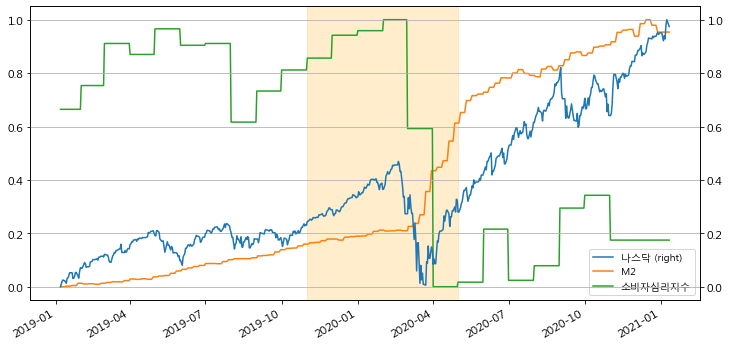

In [12]:
df1 = df[['나스닥','M2','소비자심리지수']]
ax = df1.plot(secondary_y='나스닥')
ax = ax.axvspan('2019-11-01','2020-05-01', color='orange', alpha=0.2)

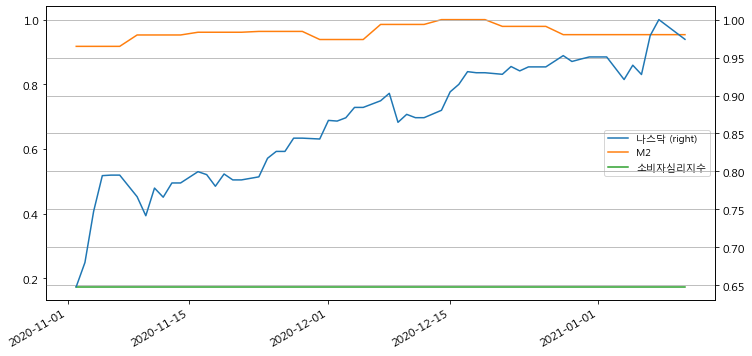

In [14]:
ax = df1.tail(60).plot(secondary_y='나스닥')

### 주가지수

[지표정보 확인](https://github.com/FinanceData/FinanceDataReader/wiki/Quick-Reference#%EC%A3%BC%EC%9A%94-%EC%A7%80%EC%88%98)

#### 종목리스트 생성

In [9]:
from openpyxl import Workbook
from pandas import ExcelWriter
import pandas as pd

stock_list = mkfile('stock_list') # 파일 경로/이름 생성
stocklist = ['SP500','NASDAQ','KRX'] # 리스트 받아올 항목 정리
wb = Workbook()
all_df = []

all_df = [fdr.StockListing(stock) for stock in stocklist]
writer = pd.ExcelWriter(stock_list, engine='xlsxwriter') 

for idx,sheet in enumerate(all_df):
    sheet.to_excel(writer, sheet_name = stocklist[idx],header=True,index=False, encoding ='euckr')
writer.save()

C:\Dev\Miniconda3\lib\site-packages\FinanceDataReader\wikipedia\listing.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Symbol'] = df['Symbol'].str.replace('\.', '')
100%|█████████████████████████████████████| 3309/3309 [00:08<00:00, 387.48it/s]


#### 개별종목 주가

<AxesSubplot:xlabel='Date'>

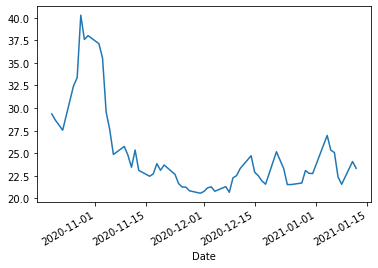

In [6]:
import FinanceDataReader as fdr

df = fdr.DataReader('VIX', '2020')
df['Close'].tail(60).plot()

In [24]:
def mp(ticker_tuple, start):
    df= pd.DataFrame()
    for name, ticker in ticker_tuple:
        df_s = fdr.DataReader(ticker, start)
        df_s = scale(df_s)
        df[name] = df_s['Close']
    return df

In [13]:
ticker_list = ['DJI','IXIC','NG','GC','SI','CL']
df= pd.DataFrame()
for ticker in ticker_list:
    df_s = fdr.DataReader(ticker, '2020')
    df_s = scale(df_s)
    df[ticker] = df_s['Close']
df

,DJI,IXIC,NG,GC,SI,CL
2020-01-02,0.821753,0.351903,0.341880,0.920476,0.124475,0.312097
2020-01-03,0.803048,0.340640,0.346154,0.911256,0.124475,0.308305
2020-01-06,0.808525,0.348635,0.348825,0.883212,0.124625,0.326128
2020-01-07,0.798954,0.348179,0.363248,0.893200,0.129874,0.290482
2020-01-08,0.811861,0.357745,0.352030,0.869381,0.131974,0.355707
...,...,...,...,...,...,...
2021-01-06,0.978525,0.927274,0.659188,0.927776,0.908968,0.847933
2021-01-07,0.995455,0.978791,0.666132,0.926623,0.989952,0.830868
2021-01-08,1.000000,1.000000,0.650641,0.935075,0.997301,0.851725
2021-01-11,0.992861,0.973895,0.675748,0.934307,0.876125,0.843762


In [29]:
t = ['US500','DJI','IXIC','VIX','KS11','NG','GC','SI','CL','US10YT=X']
n = ['S&P500','다우존스','NASDAQ','VIX','KOSPI','천연가스선물','금선물','은선물','구리선물','미국채10년물']
li = list(zip(n,t))
df1 = mp(li,'2020')

df2 = fdr.DataReader(['ICSA', 'UMCSENT','M2','BAMLH0A0HYM2'],'2020', data_source='fred')
col = ['하이일드채권스프레드','소비자심리지수','M2','실업수당건수']
df2.columns = col
df2 = scale(df2)
pd.concat([df1,df2], axis=1).corr()

,S&P500,다우존스,NASDAQ,VIX,KOSPI,천연가스선물,금선물,은선물,구리선물,미국채10년물,하이일드채권스프레드,소비자심리지수,M2,실업수당건수
S&P500,1.000000,0.967011,0.935293,-0.765955,0.948570,0.729631,0.486397,0.660560,0.892516,0.183906,-0.873439,-0.016572,0.561835,-0.596019
다우존스,0.967011,1.000000,0.816982,-0.838954,0.885769,0.623333,0.642637,0.596838,0.792437,0.399468,-0.948045,0.190917,0.354493,-0.645418
NASDAQ,0.935293,0.816982,1.000000,-0.572524,0.940645,0.768162,0.218907,0.688953,0.927209,-0.136321,-0.671938,-0.299550,0.797431,-0.464388
VIX,-0.765955,-0.838954,-0.572524,1.000000,-0.619538,-0.260399,-0.553671,-0.291982,-0.502735,-0.415172,0.824153,-0.146463,-0.197204,0.448832
KOSPI,0.948570,0.885769,0.940645,-0.619538,1.000000,0.715574,0.462722,0.810859,0.885372,0.080942,-0.774171,-0.137951,0.639131,-0.507888
천연가스선물,0.729631,0.623333,0.768162,-0.260399,0.715574,1.000000,0.072940,0.521843,0.781396,-0.010574,-0.489703,-0.097321,0.580389,-0.376370
금선물,0.486397,0.642637,0.218907,-0.553671,0.462722,0.072940,1.000000,0.526091,0.302266,0.761191,-0.708133,0.567374,-0.303029,-0.472239
은선물,0.660560,0.596838,0.688953,-0.291982,0.810859,0.521843,0.526091,1.000000,0.690293,0.110231,-0.469521,-0.133800,0.455656,-0.256220
구리선물,0.892516,0.792437,0.927209,-0.502735,0.885372,0.781396,0.302266,0.690293,1.000000,-0.079772,-0.666286,-0.236955,0.692022,-0.417742
미국채10년물,0.183906,0.399468,-0.136321,-0.415172,0.080942,-0.010574,0.761191,0.110231,-0.079772,1.000000,-0.538204,0.869042,-0.635201,-0.440196


In [17]:
import pandas as pd

company = '005930'
tp = '4'
ft = 'Y'
url = f'https://navercomp.wisereport.co.kr/v2/company/ajax/cF1001.aspx?cmp_cd={company}&fin_typ=0&freq_typ={ft}&encparam=cFFCNXNLMTh5MUJjSlF1aE8zYlpOUT09&id=aFVlanREZS'

dfs = pd.read_html(url,encoding='utf-8')
df = dfs[1]
# df = df.set_index('주요재무정보')
df

주요재무정보                연간                                      \
        주요재무정보 2015/12  (IFRS연결) 2016/12  (IFRS연결) 2017/12  (IFRS연결)   
0          매출액      2.006535e+06      2.018667e+06      2.395754e+06   
1         영업이익      2.641340e+05      2.924070e+05      5.364500e+05   
2   영업이익(발표기준)      2.641340e+05      2.924070e+05      5.364500e+05   
3     세전계속사업이익      2.596100e+05      3.071370e+05      5.619600e+05   
4        당기순이익      1.906010e+05      2.272610e+05      4.218670e+05   
5    당기순이익(지배)      1.869460e+05      2.241570e+05      4.134460e+05   
6   당기순이익(비지배)      3.655000e+03      3.104000e+03      8.422000e+03   
7         자산총계      2.421795e+06      2.621743e+06      3.017521e+06   
8         부채총계      6.311970e+05      6.921130e+05      8.726070e+05   
9         자본총계      1.790598e+06      1.929630e+06      2.144914e+06   
10    자본총계(지배)      1.728768e+06      1.864243e+06      2.072134e+06   
11   자본총계(비지배)      6.183000e+04      6.538700e+04      7.278000e+04   
12         자본금      8.975000e+03      8.975000e+03      8.975000e+03   
13    영업활동현금흐름      4.006180e+05      4.738560e+05      6.216200e+05   
14    투자활동현금흐름     -2.716780e+05     -2.965870e+05     -4.938520e+05   
15    재무활동현금흐름     -6.573500e+04     -8.669500e+04     -1.256090e+05   
16       CAPEX      2.588020e+05      2.414300e+05      4.279220e+05   
17         FCF      1.418150e+05      2.324270e+05      1.936980e+05   
18      이자발생부채      1.287400e+05      1.528240e+05      1.881400e+05   
19       영업이익률      1.316000e+01      1.449000e+01      2.239000e+01   
20        순이익률      9.500000e+00      1.126000e+01      1.761000e+01   
21      ROE(%)      1.116000e+01      1.248000e+01      2.101000e+01   
22      ROA(%)      8.070000e+00      9.010000e+00      1.496000e+01   
23        부채비율      3.525000e+01      3.587000e+01      4.068000e+01   
24       자본유보율      2.111788e+04      2.200414e+04      2.453612e+04   
25      EPS(원)      2.198000e+03      2.735000e+03      5.421000e+03   
26      PER(배)      1.147000e+01      1.318000e+01      9.400000e+00   
27      BPS(원)      2.371500e+04      2.663600e+04      3.042700e+04   
28      PBR(배)      1.060000e+00      1.350000e+00      1.670000e+00   
29    현금DPS(원)      4.200000e+02      5.700000e+02      8.500000e+02   
30     현금배당수익률      1.670000e+00      1.580000e+00      1.670000e+00   
31   현금배당성향(%)      1.642000e+01      1.781000e+01      1.409000e+01   
32  발행주식수(보통주)      7.364967e+09      7.033967e+09      6.454925e+09   

                                                             \
   2018/12  (IFRS연결) 2019/12  (IFRS연결) 2020/12(E)  (IFRS연결)   
0       2.437714e+06      2.304009e+06           2371630.00   
1       5.888670e+05      2.776850e+05            366852.00   
2       5.888670e+05      2.776850e+05                  NaN   
3       6.116000e+05      3.043220e+05            382188.00   
4       4.434490e+05      2.173890e+05            275506.00   
5       4.389090e+05      2.150510e+05            273157.00   
6       4.540000e+03      2.338000e+03                  NaN   
7       3.393572e+06      3.525645e+06           3751658.00   
8       9.160410e+05      8.968410e+05            936084.00   
9       2.477532e+06      2.628804e+06           2815779.00   
10      2.400690e+06      2.549155e+06           2732840.00   
11      7.684200e+04      7.964900e+04                  NaN   
12      8.975000e+03      8.975000e+03              8979.00   
13      6.703190e+05      4.538290e+05            572889.00   
14     -5.224050e+05     -3.994820e+05           -369861.00   
15     -1.509020e+05     -9.484500e+04            -96864.00   
16      2.955640e+05      2.536780e+05            349915.00   
17      3.747550e+05      2.001520e+05            226414.00   
18      1.466710e+05      1.841200e+05                  NaN   
19      2.416000e+01      1.205000e+01                15.47   
20      1.819000e+01      9.440000e+00                11.62   
21      1.963000e+01      8.690000e+00

In [9]:
dfs[1]

ì£¼ìì¬ë¬´ì ë³´                ì°ê°                        \
            ì£¼ìì¬ë¬´ì ë³´ 2015/12  (IFRSì°ê²°) 2016/12  (IFRSì°ê²°)   
0                    ë§¤ì¶ì¡          2.006535e+06          2.018667e+06   
1                 ìì
ì´ìµ          2.641340e+05          2.924070e+05   
2   ìì
ì´ìµ(ë°íê¸°ì¤)          2.641340e+05          2.924070e+05   
3     ì¸ì ê³ìì¬ì
ì´ìµ          2.596100e+05          3.071370e+05   
4              ë¹ê¸°ìì´ìµ          1.906010e+05          2.272610e+05   
5      ë¹ê¸°ìì´ìµ(ì§ë°°)          1.869460e+05          2.241570e+05   
6   ë¹ê¸°ìì´ìµ(ë¹ì§ë°°)          3.655000e+03          3.104000e+03   
7                 ìì°ì´ê³          2.421795e+06          2.621743e+06   
8                 ë¶ì±ì´ê³          6.311970e+05          6.921130e+05   
9                 ìë³¸ì´ê³          1.790598e+06          1.929630e+06   
10        ìë³¸ì´ê³(ì§ë°°)          1.728768e+06          1.864243e+06   
11     ìë³¸ì´ê³(ë¹ì§ë°°)          6.183000e+04          6.538700e+04   
12                   ìë³¸ê¸          8.975000e+03          8.975000e+03   
13    ìì
íëíê¸íë¦          4.006180e+05          4.738560e+05   
14    í¬ìíëíê¸íë¦         -2.716780e+05         -2.965870e+05   
15    ì¬ë¬´íëíê¸íë¦         -6.573500e+04         -8.669500e+04   
16                       CAPEX          2.588020e+05          2.414300e+05   
17                         FCF          1.418150e+05          2.324270e+05   
18          ì´ìë°ìë¶ì±          1.287400e+05          1.528240e+05   
19              ìì
ì´ìµë¥          1.316000e+01          1.449000e+01   
20                 ìì´ìµë¥          9.500000e+00          1.126000e+01   
21                      ROE(%)          1.116000e+01          1.248000e+01   
22                      ROA(%)          8.070000e+00          9.010000e+00   
23                ë¶ì±ë¹ì¨          3.525000e+01          3.587000e+01   
24             ìë³¸ì ë³´ì¨          2.111788e+04          2.200414e+04   
25                    EPS(ì)          2.198000e+03          2.735000e+03   
26                    PER(ë°°)          1.147000e+01          1.318000e+01   
27                    BPS(ì)          2.371500e+04          2.663600e+04   
28                    PBR(ë°°)          1.060000e+00          1.350000e+00   
29              íê¸DPS(ì)          4.200000e+02          5.700000e+02   
30        íê¸ë°°ë¹ììµë¥          1.670000e+00          1.580000e+00   
31       íê¸ë°°ë¹ì±í¥(%)          1.642000e+01          1.781000e+01   
32  ë°íì£¼ìì(ë³´íµì£¼)          7.364967e+09          7.033967e+09   

                                                                      \
   2017/12  (IFRSì°ê²°) 2018/12  (IFRSì°ê²°) 2019/12  (IFRSì°ê²°)   
0           2.395754e+06          2.437714e+06          2.304009e+06   
1           5.364500e+05          5.888670e+05          2.776850e+05   
2           5.364500e+05          5.888670e+05          2.776850e+05   
3           5.619600e+05          6.116000e+05          3.043220e+05   
4           4.218670e+05          4.434490e+05          2.173890e+05   
5           4.134460e+05          4.389090e+05          2.150510e+05   
6           8.422000e+03          4.540000e+03          2.338000e+03   
7           3.017521e+06          3.393572e+06          3.525645e+06   
8           8.726070e+05          9.160410e+05          8.968410e+05   
9           2.144914e+06          2.477532e+06          2.628804e+06   
10          2.072134e+06          2.400690e+06          2.549155e+06   
11          7.278000e+04          7.684200e+04          7.964900e+04   
12          8.975000e+03          8.975000e+03          8.975000e+03   
13          6.216200e+05          6.703190e+05          4.538290e+05   
14         -4.938520e+05         -5.224050e+05         -3.994820e+05   
15         -1.256090e+05         -1.509020e+05         -9